In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from PIL import Image

In [3]:
dataset = MNIST(root = 'data/', download = True)
print(len(dataset))

60000


Label: 3


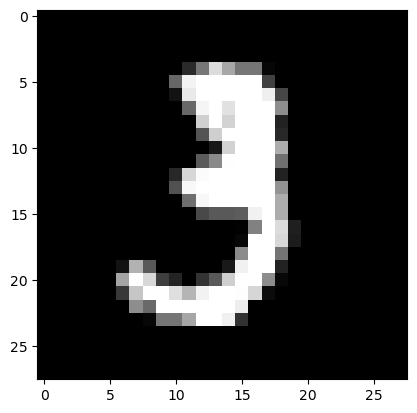

In [4]:
image, label = dataset[10]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

In [5]:
mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())
print(mnist_dataset)
image_tensor, label = mnist_dataset[0]
print(image_tensor.shape, label)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([1, 28, 28]) 5


In [6]:
train_data, test_data = random_split(mnist_dataset, [50000, 10000])

In [7]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size, shuffle = False)

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [9]:
print(f"Using {device} device")

Using cpu device


Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


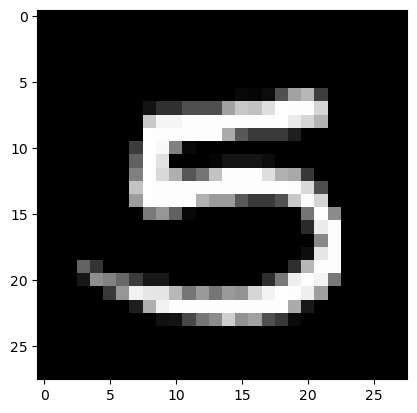

Label: 5


In [10]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,64,3,1)#26*26
        self.pool = nn.MaxPool2d(2,2)#13*13
        self.conv2 = nn.Conv2d(64,128,3,1)#11*11
        self.fc1 = nn.Linear(128*5*5,1024)#5*5
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,128)
        self.fc4 = nn.Linear(128,10)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
net = CNN().to(device)        

In [12]:
loss_criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = net.parameters(),lr = 0.001)
epoch = 5
epoch_nums = []
training_loss = []
validation_loss = []

In [13]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = loss_criteria(output, labels)

        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                    
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [14]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, labels in test_loader:
            batch_count += 1
            data, labels = data.to(device), labels.to(device)
            
            output = model(data)
            
            test_loss += loss_criteria(output, labels).item()
            
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(labels==predicted).item()

    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return avg_loss

In [15]:
print('Training on', device)
for epoch in range(1, epoch + 1):
        train_loss = train(net, device, train_loader, optimizer, epoch)
        test_loss = test(net, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set: Average loss: 0.221894
Validation set: Average loss: 0.065646, Accuracy: 9795/10000 (98%)

Epoch: 2
Training set: Average loss: 0.051981
Validation set: Average loss: 0.057159, Accuracy: 9843/10000 (98%)

Epoch: 3
Training set: Average loss: 0.036267
Validation set: Average loss: 0.039758, Accuracy: 9889/10000 (99%)

Epoch: 4
Training set: Average loss: 0.025385
Validation set: Average loss: 0.047345, Accuracy: 9859/10000 (99%)

Epoch: 5
Training set: Average loss: 0.020223
Validation set: Average loss: 0.041959, Accuracy: 9879/10000 (99%)



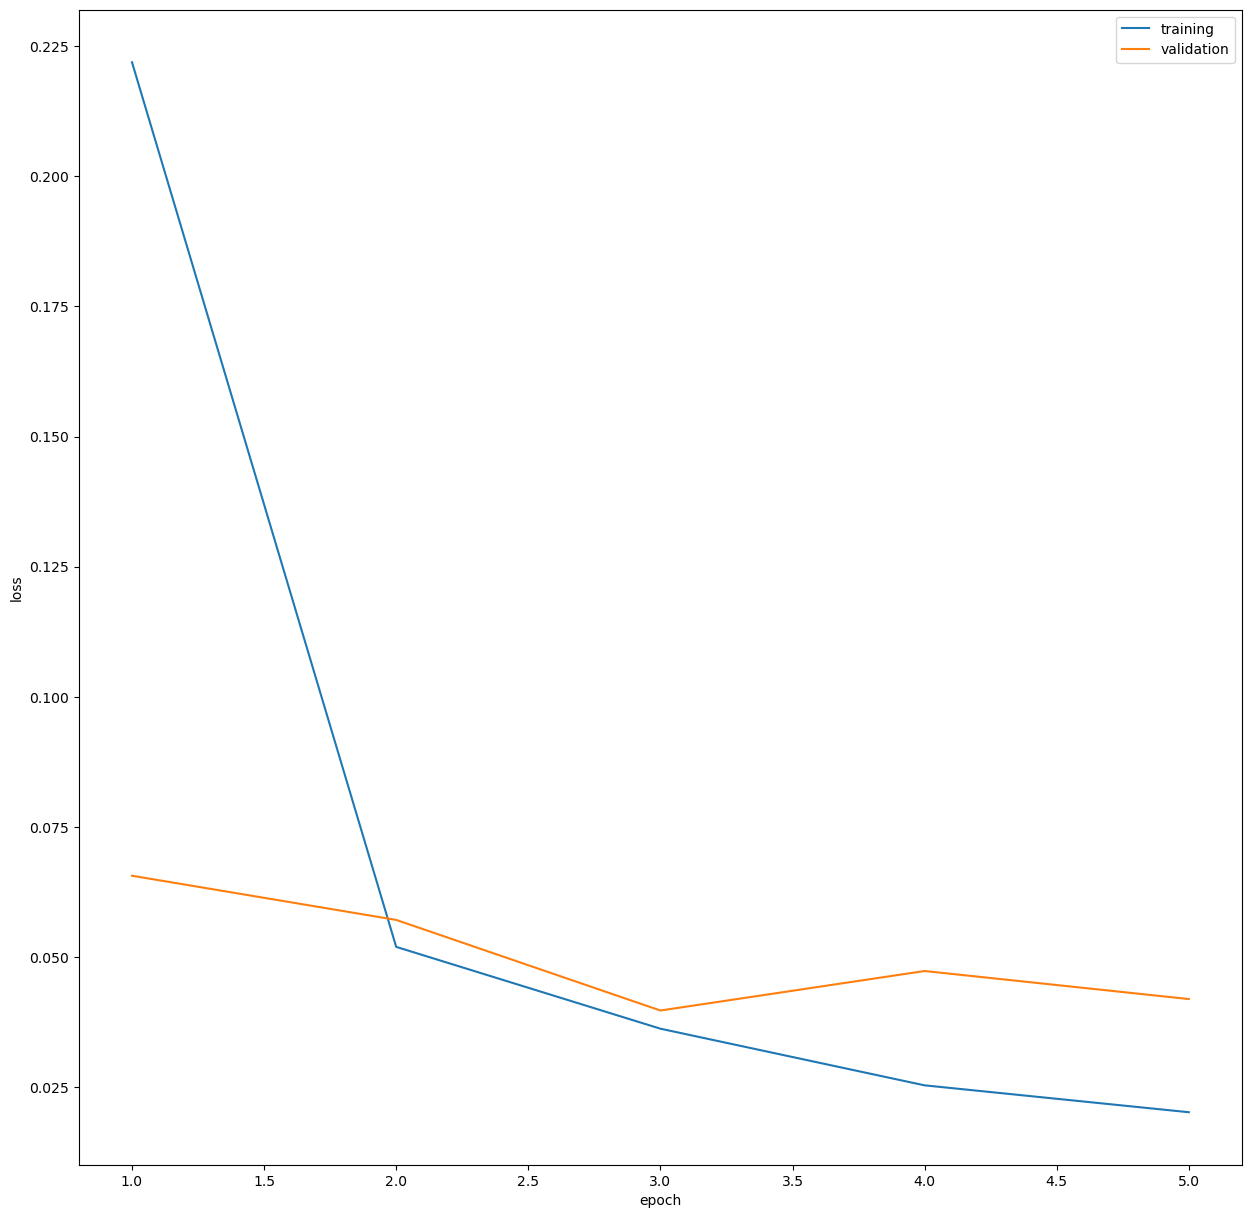

In [16]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [17]:
torch.save(net, 'model.pth')

In [18]:
model = torch.load('model.pth')

In [35]:
transform = transforms.ToTensor()

image = Image.open("img.jpg").convert('L')

image = transform(image).unsqueeze(0)

In [36]:
output = model(image)
predicted_class = output.argmax(1)  
print("Predicted class:", predicted_class.item())

Predicted class: 9


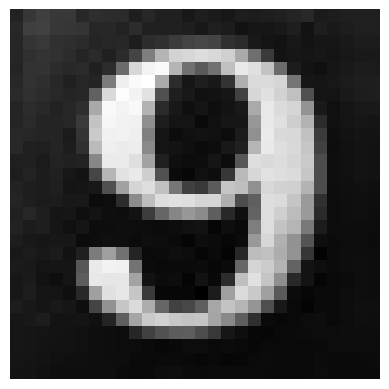

In [38]:
image = np.squeeze(image)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()